<a href="https://colab.research.google.com/github/linhtrinh213/Interpretable_VAE_TF_regulons/blob/main/VEGA_sti_Philippe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1: Necessities and Data


Downloading Necessities

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#### Library Setup ####
# install and import required packages
!pip install scanpy
!pip install decoupler
!pip install omnipath

import torch; torch.manual_seed(100)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import scanpy as sc
from collections import OrderedDict
from collections import Counter

# select the right device, depending on whether your Colab runs on GPU or CPU
### IMPORTANT: we recommend to change your runtime to GPU, otherwise the training takes much longer
device = 'mps'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
   

PBMC Data download

In [3]:
# download the data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG' -O PBMC_train.h5ad
# Load data and use Scanpy to convert it into AnnData
PBMC_train = sc.read_h5ad("PBMC_train.h5ad")

--2025-05-19 11:43:52--  https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG
Resolving docs.google.com (docs.google.com)... 172.217.203.113, 172.217.203.139, 172.217.203.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG&export=download [following]
--2025-05-19 11:43:52--  https://drive.usercontent.google.com/download?id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.134.132, 2607:f8b0:400c:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.134.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45277554 (43M) [application/octet-stream]
Saving to: ‘PBMC_train.h5ad’

PBMC_train.h5ad     100%[===================>]  43.18M   135MB/s

In [4]:
# devide data into control and stimulated


# Subset for a specific condition, e.g., "control"
PBMC_control = PBMC_train[PBMC_train.obs["condition"] == "control"].copy()

# Another example for "treated"
PBMC_stimulated = PBMC_train[PBMC_train.obs["condition"] == "stimulated"].copy()


In [5]:
# Take a look at the data
print(PBMC_train) #the data is stored as an anndata object
print(Counter(PBMC_train.obs["cell_type"])) #summary of cell types
print(Counter(PBMC_train.obs["condition"])) #summary of conditions

AnnData object with n_obs × n_vars = 13515 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'
Counter({'CD4T': 4452, 'FCGR3A+Mono': 2881, 'CD14+Mono': 2049, 'B': 1448, 'NK': 931, 'CD8T': 892, 'Dendritic': 862})
Counter({'stimulated': 7109, 'control': 6406})


# 2: Regulon Import and Mask Creation

Regulon Import

In [6]:
### CollecTRI network: a curated collection of TFs and their transcriptional targets ###

import decoupler as dc
regulons = dc.get_collectri(organism='human', split_complexes=False)    # processed regulons

  # spilt_complexes: keep or spilt complexes into subunits
  # weight: 1 is activation. -1 is inhibition

print(regulons)


      source  target  weight
0       ABL1     BAX       1
1       ABL1    BCL2      -1
2       ABL1    BCL6      -1
3       ABL1   CCND2       1
4       ABL1  CDKN1A       1
...      ...     ...     ...
40625   ZXDC  CDKN1C       1
40626   ZXDC  CDKN2A       1
40627   ZXDC   CIITA       1
40628   ZXDC   HLA-E       1
40629   ZXDC     IL5       1

[40630 rows x 3 columns]


In [7]:
####### In the following sections, we used and adapted code from https://github.com/LucasESBS/vega ######
####### Here the mask is created and added to adata #######
import pandas as pd
import numpy as np



def create_mask(adata, regulons, add_nodes:int=10, sep = "\t"):
    """
    Initialize mask M that specifies which latent nodes connect to which decoder nodes.
    Args:
        adata (Anndata): Scanpy single-cell object, we will store the computed mask and the names of the biological processes there
        regulons: which TFs affected which genes
        add_nodes (int): Additional latent nodes for capturing additional variance
    Return:
        adata (Anndata): Scanpy single-cell object that now stores the computed mask and the names of biological processes (in the .uns["_vega"] attribute)
        mask (array): mask M that specifies whether a gene is included in the gene set of a pathway (value one) or not (value zero)
    """

    # Create the mask
    # 1. Get unique genes (targets) and TFs (sources)
    genes = regulons['target'].unique()
    tfs = regulons['source'].unique()

    #Get TFs of interest
    selected_tfs = (
    "STAT1",
    "STAT2",
    "STAT3",
    "STAT4",
    "STAT5A",
    "STAT5B",
    "STAT6",
    "IRF1",
    "IRF2",
    "IRF3",
    "IRF4",
    "IRF5",
    "IRF6",
    "IRF7",
    "IRF8",
    "IRF9",
    "NFKB",
    "AP1",
    "MYC",
    "TP53",
    )

    # 2. Initialize matrix M with zeros
    M = pd.DataFrame(0, index=genes, columns=tfs)

    # 3. Set M[i,j] = 1 where the gene i is affected by TF j
    for _, row in regulons.iterrows(): # for each row in regulons
        M.loc[row['target'], row['source']] = 1 #the corresponding genes, TF box = 1

    #Selects only columns with TF of interest, keeps all rows (Genes)
    M = M.loc[:, selected_tfs]  #if M is a pandas DataFrame

    # Add unannotated nodes
    vec = np.ones((M.shape[0], add_nodes))
    M = np.hstack((M, vec))

    adata.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
    adata.uns['_vega']['mask'] = M
    adata.uns['_vega']['TFs'] = list(tfs) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]


    return adata, M

In [8]:
PBMC_stimulated, mask = create_mask(PBMC_stimulated, regulons, add_nodes=1)

print(mask)
print(mask.shape)

[[1. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(6627, 21)


# 3: Gene Filtering

In [9]:
#### Filter the Genes ####

#Add gene names to the mask to filter below
mask_df = pd.DataFrame(mask, index = regulons.target.unique())

#List of genes found in regulons data and PBMC data
regulons_genes = np.array(regulons.target.unique())
pbmc_genes = np.array(PBMC_train.var_names)

#Create boolean filter of what regulons genes are in pbmc data
keep = np.isin(regulons_genes, pbmc_genes)

#Apply filter - Get mask with TFs of interest as col and relevant genes as rows.
filtered_mask_df = mask_df.loc[keep, :]

#Remove genes that are controlled by less than 2 TFs
non_zero_count = np.count_nonzero(filtered_mask_df, axis = 1)
filtered_mask_df = filtered_mask_df[non_zero_count >= 2]

filtered_mask_df.shape

(1072, 21)

In [10]:
#Filter Genes in PBMC data
PBMC_stimulated_filtered = PBMC_stimulated[:, filtered_mask_df.index].copy()
PBMC_stimulated_filtered.shape

(7109, 1072)

In [11]:
#Convert pandas.DataFrame -> numpy.array for later use
filtered_mask = filtered_mask_df.to_numpy()

# 4: VEGA Components
Here are defined the encoder, decoder



In [12]:
# Define Encoder:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout between the dense layers, z_dropout define the dropout rates between the encoder/latent space
        super(Encoder, self).__init__() #run the initialize code from nn.Module -> this class behaves like a Pytorch model
        self.encoder = nn.Sequential(
                                     nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout

        # outputs mean vector u
        self.mu = nn.Sequential(nn.Linear(800, latent_dims), # the 800 neurons in the second layers -> latent space
                                nn.Dropout(p = z_dropout))
        # outputs standard variance
        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)  # define Gaussian distribution for each input
        self.N.loc = self.N.loc.to(device) # move to the right device
        self.N.scale = self.N.scale.to(device)
        self.kl = 0 # place holder for storing KL divergence (regularization term)
        # KL measures how far the learned Gaussian is from the standard normal (0,1) -> this is a regularization term in VAE
    def forward(self, x):
        x = self.encoder(x) # pass the data to the encoder
        mu =  self.mu(x) # predict mean vector
        sigma = torch.exp(self.sigma(x)) # predict standard var exp for numeric stability
        z = mu + sigma*self.N.sample(mu.shape)  # Sample z using reparameterization trick

        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z # output is the sampled latent vector


In [13]:
# define VEGA's decoder (which is adapted to enable biologcal intepretability )

class DecoderVEGA(nn.Module):
  """
  Define VEGA's decoder (sparse, one-layer, linear)
  """
  def __init__(self, mask):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask)) # we define the architecture of the decoder below with the class "SparseLayer"

  def forward(self, x):
    z = self.sparse_layer(x.to(device)) # pass the latent representation x -> predict gene expression z
    return(z)


# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class SparseLayer(nn.Module):
  def __init__(self, mask):
        """
        Extended torch.nn module which mask connection
        """
        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False) # mask: binary matrix of shape (genes, TFs) — entry (i, j) = 1 if TF j regulates gene i.
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0])) # mask dimension: in our cases 1164, 6627 ()
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1])) #there should be in total 1164 nodes aka TF in the latent space -> hence 1164 biases
        self.reset_parameters()

        # mask weight
        self.weight.data = self.weight.data * self.mask # All connections not allowed by the mask are zeroed out

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1)) #
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input):
        # See the autograd section for explanation of what happens here
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask)


######### You don't need to understand this part of the code in detail #########
# SparseLayerFunction: Custom gradient-aware layer to apply the mask during both forward and backward passes
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):

        weight = weight * mask # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            # change grad_weight to 0 where mask == 0
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask



In [14]:
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(VEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

The training loop is defined below

In [15]:
#training loop
def trainVEGA(vae, data, epochs=30, beta = 0.0001, learning_rate = 0.01):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    vae.train() #train mode
    losses = []
    klds = []
    mses = []

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

# 5: Model Training

In [16]:
# NOTE: In Runtime, Change type (hardware accelerator) -> GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
# Set up training data for each VEGA for pyTorch
PBMC_stimulatedX = torch.utils.data.DataLoader(PBMC_stimulated_filtered.X.toarray(), batch_size=128)


In [18]:
# instantiate the model as vega_sti
vega_sti = VEGA(latent_dims= filtered_mask.shape[1], input_dims = filtered_mask.shape[0], mask = filtered_mask.T, z_dropout = 0.1, dropout = 0.2).to(device)
# Train vega_ctr on the control data
vega_sti, vega_losses_sti, vega_klds_sti, vega_mses_sti = trainVEGA(vega_sti, PBMC_stimulatedX, epochs = 40, beta = 0.00001) #takes about 2 mins on GPU

epoch:  0  loss:  194.77135
epoch:  1  loss:  95.80159
epoch:  2  loss:  83.58213
epoch:  3  loss:  86.75919
epoch:  4  loss:  89.35408
epoch:  5  loss:  82.87059
epoch:  6  loss:  78.403206
epoch:  7  loss:  80.37288
epoch:  8  loss:  80.718124
epoch:  9  loss:  75.834
epoch:  10  loss:  76.403854
epoch:  11  loss:  77.173096
epoch:  12  loss:  77.31053
epoch:  13  loss:  74.58031
epoch:  14  loss:  73.87342
epoch:  15  loss:  74.02635
epoch:  16  loss:  74.180176
epoch:  17  loss:  76.56585
epoch:  18  loss:  76.79456
epoch:  19  loss:  77.54322
epoch:  20  loss:  74.62183
epoch:  21  loss:  73.04167
epoch:  22  loss:  72.9135
epoch:  23  loss:  72.64004
epoch:  24  loss:  72.630516
epoch:  25  loss:  72.9125
epoch:  26  loss:  73.10784
epoch:  27  loss:  77.56889
epoch:  28  loss:  74.14441
epoch:  29  loss:  73.22738
epoch:  30  loss:  72.58018
epoch:  31  loss:  72.28894
epoch:  32  loss:  72.82385
epoch:  33  loss:  73.64611
epoch:  34  loss:  74.971245
epoch:  35  loss:  77.9794

In [19]:
# Saving the Weights
torch.save(vega_sti.state_dict(), '/content/drive/MyDrive/Colab ML/VEGA/data/weights_sti_base.pth')

### Loading the weights
#args = (filtered_mask.shape[1], filtered_mask.shape[0], filtered_mask.T, 0.1, 0.2)
#vega_sti = VEGA(*args)
#vega_sti.load_state_dict(torch.load('/content/drive/MyDrive/Colab ML/VEGA/data/weights_sti_base.pth'))

# 6: Inspecting Model Weights


In [20]:
# Looking at the weights of the model
vega_sti.state_dict()

OrderedDict([('encoder.encoder.0.weight',
              tensor([[-6.8043e-02, -4.6026e-02, -5.5170e-02,  ...,  1.4099e-11,
                       -6.8743e-02, -4.0355e-02],
                      [-2.3068e-02,  1.7649e-02, -1.4496e-21,  ..., -2.9867e-39,
                       -1.9865e-02, -4.7202e-18],
                      [ 9.7585e-03,  4.3001e-02, -1.2518e-39,  ..., -3.7778e-39,
                       -4.9176e-02,  1.4659e-38],
                      ...,
                      [-6.4143e-04, -4.7404e-02, -6.5270e-41,  ...,  7.7319e-10,
                       -2.2806e-39,  2.0463e-39],
                      [ 3.1143e-40, -4.7967e-02, -1.5207e-16,  ..., -1.1815e-39,
                        1.4608e-39, -3.2954e-02],
                      [-6.8063e-02, -7.4388e-02, -6.7254e-02,  ..., -9.3940e-40,
                       -4.8206e-02, -5.7421e-02]])),
             ('encoder.encoder.0.bias',
              tensor([-3.6812e-02, -6.5845e-02, -6.8010e-02, -1.2273e-01, -7.7562e-02,
               

In [21]:
# Getting the node number for latent and output layer
vega_sti.state_dict()["decoder.sparse_layer.0.mask"].shape

torch.Size([1072, 21])

tensor([[-0.0000, -0.0000, -0.0011,  ...,  0.0015, -0.0082, -0.0024],
        [-0.0000,  0.0000, -0.0019,  ...,  0.0044, -0.0006, -0.0005],
        [ 0.0003, -0.0000,  0.0000,  ...,  0.0015,  0.0000, -0.0014],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0026,  0.0052],
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0223, -0.0023],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0005,  0.0011]])
torch.Size([1072, 21])


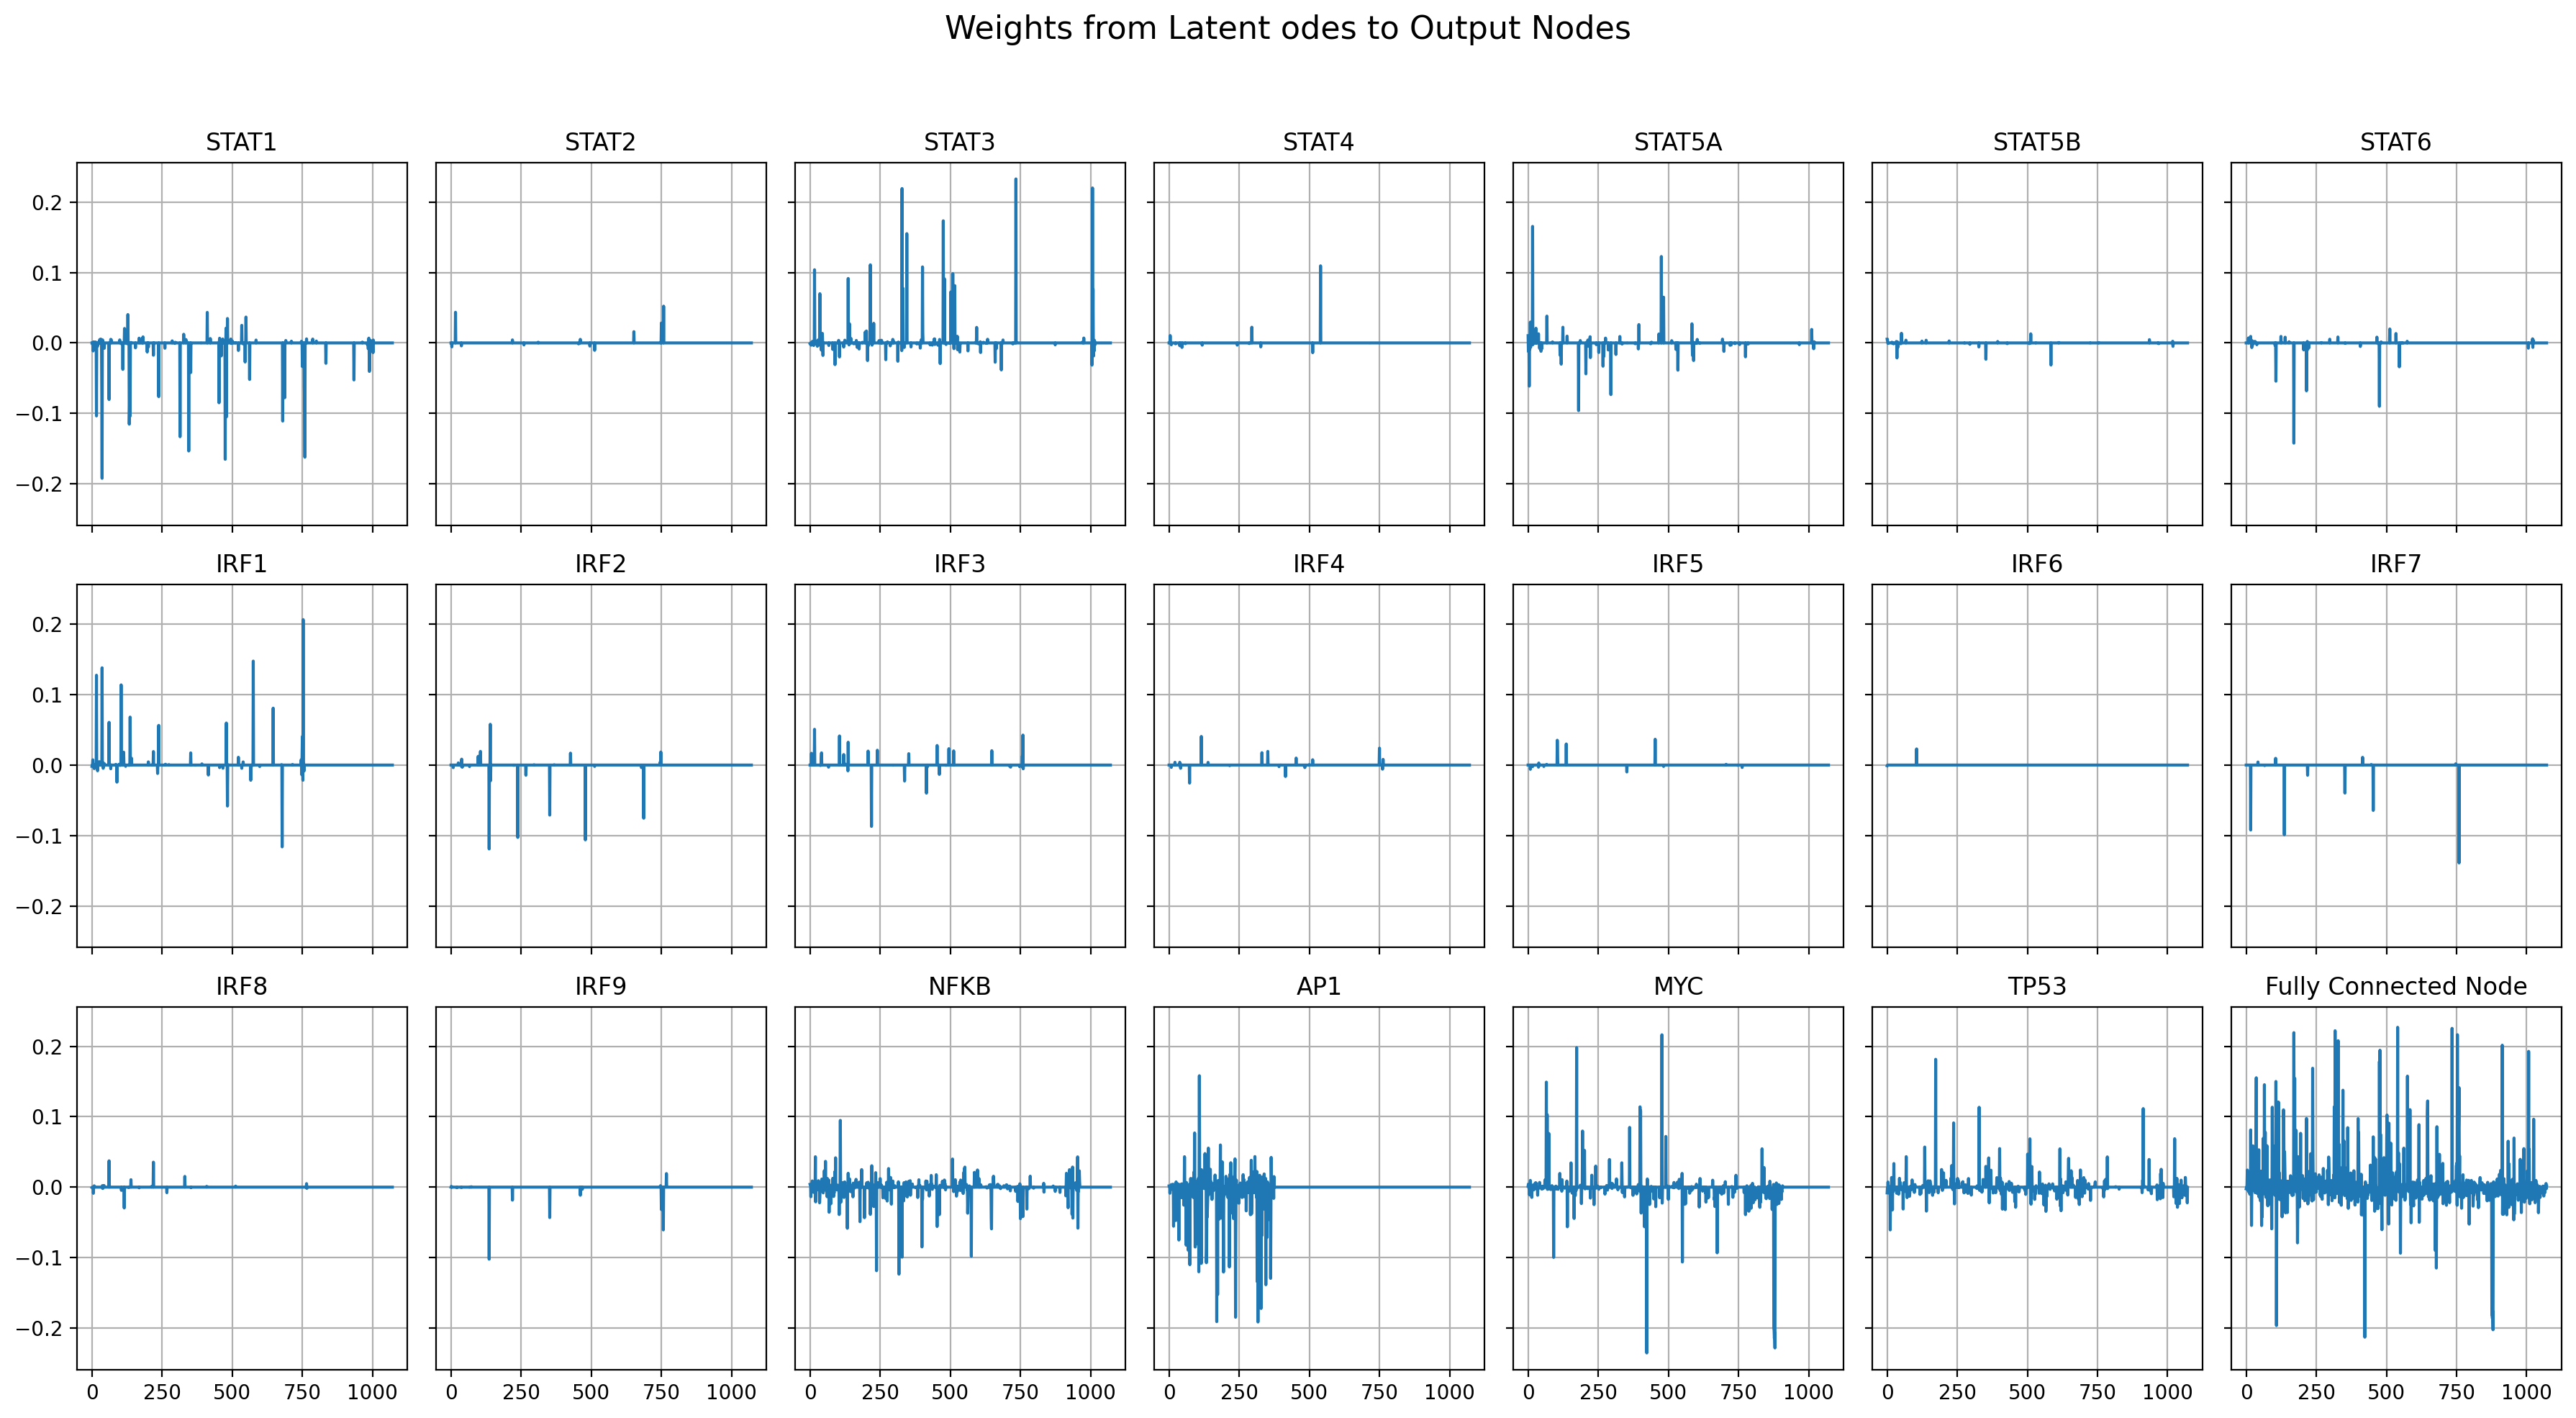

In [26]:
#### Plotting the biologicaly relevant weights ####

weights = vega_sti.state_dict()["decoder.sparse_layer.0.weight"]
num_latent = vega_sti.state_dict()["decoder.sparse_layer.0.weight"].shape[1]
num_cols = 7  #Number of columns in the plot
num_rows = (num_latent + num_cols -1) // num_cols #Automatically calculate rows

fig, axes = plt.subplots(num_rows, num_cols, figsize = (18,10), sharex = True, sharey = True)

selected_tfs =(
    "STAT1",
    "STAT2",
    "STAT3",
    "STAT4",
    "STAT5A",
    "STAT5B",
    "STAT6",
    "IRF1",
    "IRF2",
    "IRF3",
    "IRF4",
    "IRF5",
    "IRF6",
    "IRF7",
    "IRF8",
    "IRF9",
    "NFKB",
    "AP1",
    "MYC",
    "TP53",
    "Fully Connected Node")

# Create plot for each TF
for i in range(num_latent):
  row = i // num_cols
  col = i % num_cols
  ax = axes[row,col]

  weights_from_z = weights[:, i].cpu().numpy()
  ax.plot(weights_from_z)
  ax.set_title(selected_tfs[i])
  ax.grid(True)

# Hide unused subplots
for j in range(num_latent, num_rows *num_cols):
  fig.delaxes(axes[j // num_cols, j % num_cols])

fig.suptitle("Weights from Latent odes to Output Nodes", fontsize = 16)
fig.tight_layout(rect = [0,0,1,0.95])
plt.show()